In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import ot
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from data import sample_8gaussians, sample_moons
from softsort import SoftSort_p2 as SoftSort
from models import MLPWithSkipConnections, SetTransformer
from visualize import planner 
from lapsum import soft_permutation
import copy

## 1. Generate Task Sequence

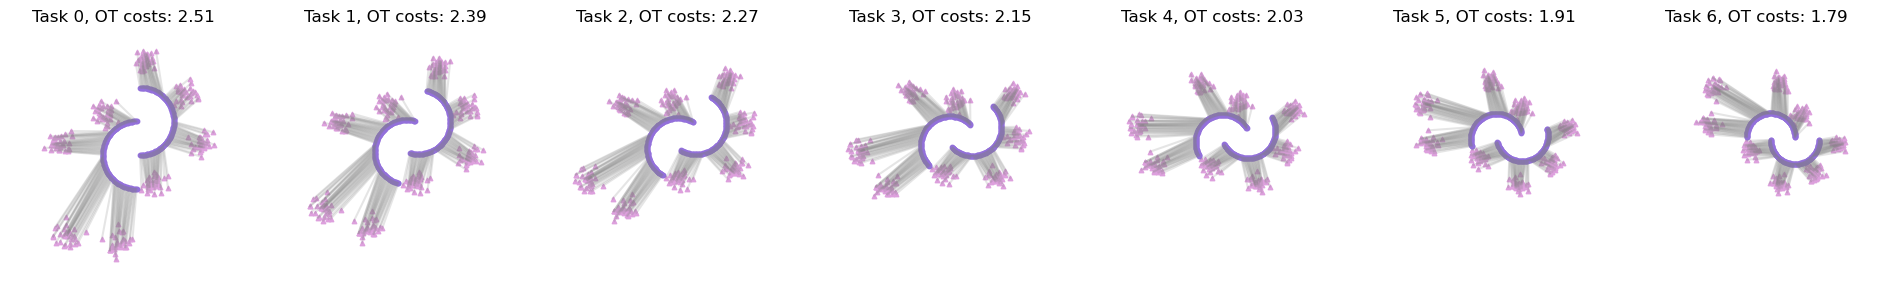

In [ ]:
from fractions import Fraction

N = 256
X = sample_8gaussians(N).detach().numpy()
Y = sample_moons(N).detach().numpy()

T = 7
ts = np.linspace(0, 1, T)

def rotation_matrix(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]])

def transform_points(points, t, max_angle=np.pi/2, max_scale=1.2):
    """
    Apply stronger rotation + scaling to the whole dataset.
    """
    theta = t * max_angle
    scale = 0.5 + (max_scale - 1.0) * t
    R = rotation_matrix(theta)
    return points @ R.T * scale

# Apply transform to both X and Y
frames = []
for t in ts:
    Xt = transform_points(X, t)
    Yt = transform_points(Y, t)
    frames.append((Xt, Yt))

frames = frames[::-1]


# --- determine global axis limits ---
all_points = np.vstack([np.vstack((Xt, Yt)) for Xt, Yt in frames])
x_min, x_max = all_points[:,0].min(), all_points[:,0].max()
y_min, y_max = all_points[:,1].min(), all_points[:,1].max()

# Add margin
margin = 0.1 * max(x_max - x_min, y_max - y_min)
x_min -= margin
x_max += margin
y_min -= margin
y_max += margin

cs = []
for (X, Y) in frames:
    M = ot.dist(X, Y, metric='euclidean')
    a = np.ones(N) / N
    b = np.ones(N) / N
    P = ot.emd(a, b, M)
    cs.append(ot.emd2(a, b, M))
    # planner(X,Y,P,title='OT Plan', show_cost=False)
    
# # --- visualize ---
fig, axes = plt.subplots(1, T, figsize=(24, 4))

for i, (X, Y) in enumerate(frames):
    M = ot.dist(X, Y, metric='euclidean')
    a = np.ones(N) / N
    b = np.ones(N) / N
    P = ot.emd(a, b, M)
    planner(X, Y, P, ax=axes[i], title=f"Task {i}, OT costs: {cs[i]:.2f}", show_cost=False)
    axes[i].axis("off")
    axes[i].set_xlim([x_min, x_max])
    axes[i].set_ylim([y_min, y_max])
    axes[i].get_legend().remove()


plt.show()


In [ ]:
## Plot Level Curves Function
def plot_level_curves(x_min, x_max, y_min, y_max, model, device="cpu",
                      n_points=200, levels=20, ax=None, show=True, c='black', label=None, **kwargs):
    """
    
    Plots level curves for a given model in 2D.

    Args:
        x_min, x_max, y_min, y_max : float
            Bounds of the 2D grid.
        model : torch.nn.Module
            The PyTorch model that takes input (N,2) and outputs (N,1).
        device : str
            "cpu" or "cuda" device for evaluation.
        n_points : int
            Number of grid points along each axis.
        levels : int
            Number of contour levels.
        ax : matplotlib.axes.Axes, optional
            Existing axes to plot on. If None, a new one is created.
        show : bool
            Whether to call plt.show().
        **kwargs : dict
            Extra keyword args passed to `ax.contour`.
    Returns:
        matplotlib.contour.QuadContourSet
    """

    # Create 2D grid
    x = np.linspace(x_min, x_max, n_points)
    y = np.linspace(y_min, y_max, n_points)
    X, Y = np.meshgrid(x, y)
    points = np.stack([X.ravel(), Y.ravel()], axis=1)

    # Convert to tensor
    points_tensor = torch.tensor(points, dtype=torch.float32).to(device)

    # Evaluate model
    model.eval()
    with torch.no_grad():
        Z = model(points_tensor).cpu().numpy().reshape(X.shape)

    # Use existing ax or make new
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    contours = ax.contour(X, Y, Z, levels=levels, alpha=.65, colors = c, **kwargs)
    # contours.set_label(label)
    
    # ax.clabel(contours, inline=True, fontsize=8)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Level Curves")
    ax.set_aspect("equal")

    if show:
        # plt.colorbar(contours, ax=ax)
        plt.show()

    return contours

## 2. Sequential Training

Random Initialization
Begining Cost:5.414000


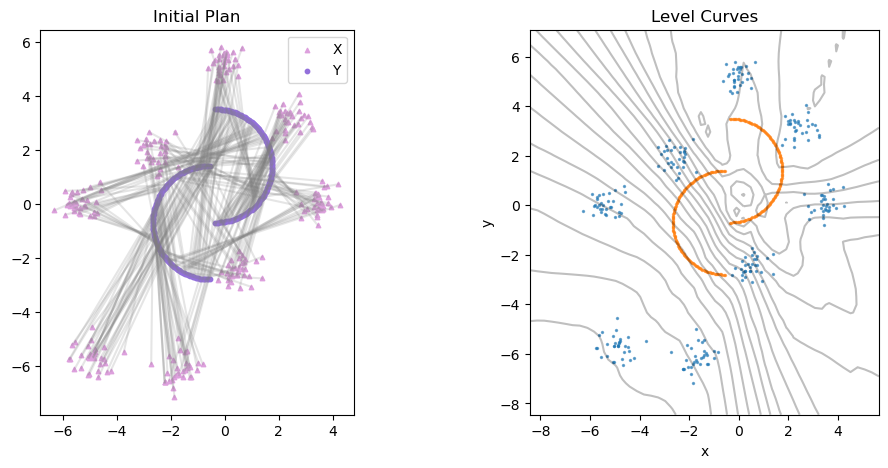

  0%|          | 0/1500 [00:00<?, ?it/s]

Current Cost:3.605286, iteration: 1
Current Cost:2.681713, iteration: 81
Current Cost:2.607164, iteration: 161
Current Cost:2.607056, iteration: 241
Current Cost:2.621207, iteration: 321
Current Cost:2.523896, iteration: 401
Current Cost:2.524440, iteration: 481
Current Cost:2.522705, iteration: 561
Current Cost:2.527992, iteration: 641
Current Cost:2.523944, iteration: 721
Current Cost:2.524955, iteration: 801
Current Cost:2.520869, iteration: 881
Current Cost:2.519341, iteration: 961
Current Cost:2.517680, iteration: 1041
Current Cost:2.518510, iteration: 1121
Current Cost:2.516456, iteration: 1201
Current Cost:2.514637, iteration: 1281
Current Cost:2.513461, iteration: 1361
Current Cost:2.512817, iteration: 1441
Final cost:2.512737


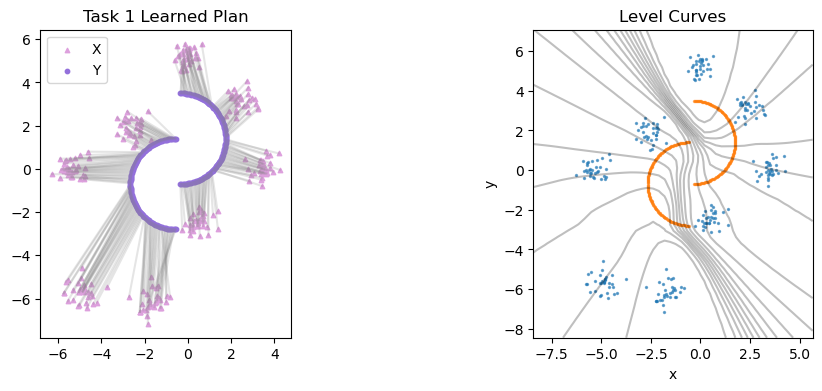

Begining Cost:2.427164


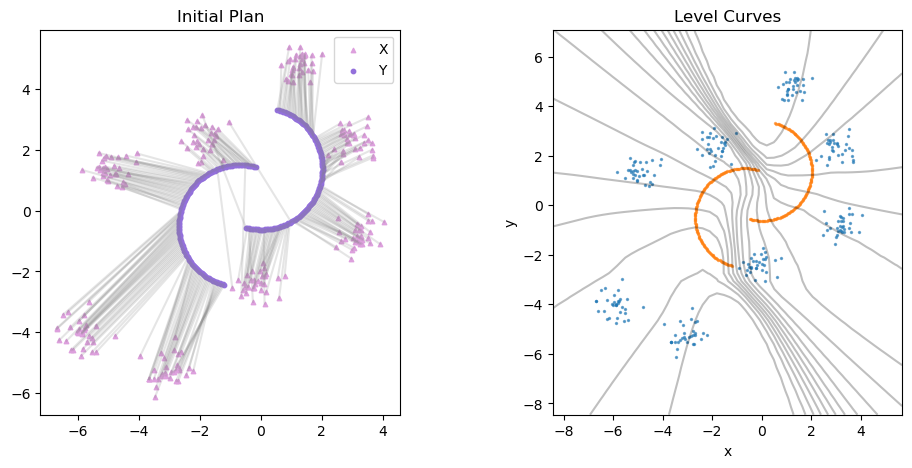

  0%|          | 0/1500 [00:00<?, ?it/s]

Current Cost:2.522147, iteration: 1
Current Cost:2.395976, iteration: 81
Current Cost:2.391750, iteration: 161
Current Cost:2.391343, iteration: 241
Current Cost:2.391240, iteration: 321
Current Cost:2.391350, iteration: 401
Current Cost:2.391360, iteration: 481
Current Cost:2.391297, iteration: 561
Current Cost:2.391015, iteration: 641
Current Cost:2.390864, iteration: 721
Current Cost:2.391007, iteration: 801
Current Cost:2.390979, iteration: 881
Current Cost:2.390777, iteration: 961
Current Cost:2.390818, iteration: 1041
Current Cost:2.390742, iteration: 1121
Current Cost:2.390648, iteration: 1201
Current Cost:2.390688, iteration: 1281
Current Cost:2.390646, iteration: 1361
Current Cost:2.390658, iteration: 1441
Final cost:2.390640


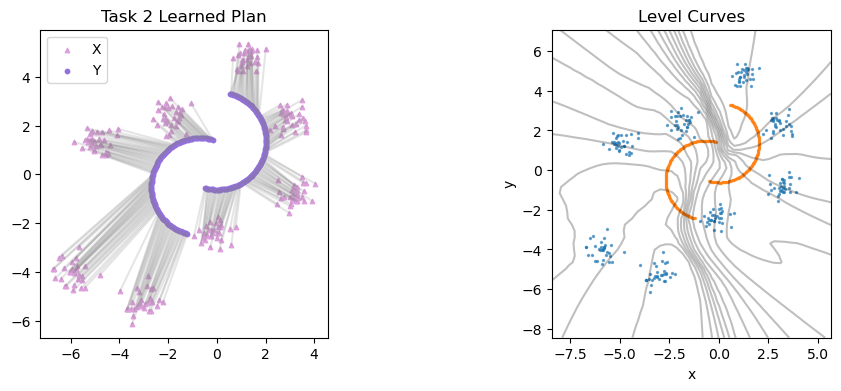

In [ ]:
bs = N
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
soft_sort = SoftSort(tau=1e-2, hard=False)
torch.autograd.set_detect_anomaly(True)
@torch.no_grad()
def update_moving_average(model, model_avg, decay=0.99):
    for p, p_avg in zip(model.parameters(), model_avg.parameters()):
        p_avg.data.mul_(decay).add_(p.data, alpha=1 - decay)

                
model_config = {
    "dim_input": 2,        # input dimension (x,y)
    "dim_output": 1,       # output dimension (scalar)
    "num_inds": 16,        # number of inducing points in ISAB
    "dim_hidden": 64,      # hidden dimension size
    "num_heads": 4,        # attention heads
    "ln": True,            # whether to use LayerNorm
    "params_budget": None  # let it use default encoder/decoder
}


# For deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



hardsort = SoftSort(hard=True)

cost_list = []
loss_list = []
best_Ps = []
best_costs = []
models = []
for run in range(1): 

    torch.manual_seed(run+2)
    torch.cuda.manual_seed_all(run+2)
    
    costs_ = []
    losses = []
    for dataid, (X, Y) in enumerate(frames[:2]):


        alpha = torch.tensor(5., requires_grad=False)

        # model= MLPWithSkipConnections(architecture=[X.shape[-1],64,128,128,64,1],activation='sin').to(device)
        # model= MLP(architecture=[d,256,256,1],activation='leakyrelu').to(device)
        model= SetTransformer(model_config).to(device)

        if dataid==0:
            print('Random Initialization')
        else:
            model.load_state_dict(torch.load(f"model_{dataid-1}_{bs}.pth"))


        optimizer = optim.AdamW(model.parameters(),lr=1e-3)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
        
        
        count = 0
            
            
        model_avg = copy.deepcopy(model)
        for p in model_avg.parameters():
            p.requires_grad_(False)


        Xtorch = torch.tensor(X, dtype=torch.float32).to(device)
        Ytorch = torch.tensor(Y, dtype=torch.float32).to(device)
        Nx, d = X.shape
        Ny, _ = Y.shape
        M = ot.dist(X, Y)
        M = np.sqrt(M)
        Mtorch = torch.tensor(M, dtype=torch.float32).to(device)
        a = torch.ones(Nx, device=device)/Nx
        b = torch.ones(Ny, device=device)/Ny

        
        Xtorch = Xtorch.to(device)
        Ytorch = Ytorch.to(device)

        Xout = model(Xtorch) 
        Yout = model(Ytorch)


        plans = ot.emd_1d(Xout, Yout, a, b)
        best_plan = plans
        costs = (plans*Mtorch).sum()
        print("Begining Cost:%f"%costs.item())
        best_cost = costs.item()
        costs_.append(costs.item())
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        planner(X, Y, plans.detach().cpu().numpy(), ax=axes[0], title='Initial Plan', show_cost=False)
        axes[1].scatter(X[:, 0], X[:, 1], s=2, c="tab:blue", alpha=0.6, label="X")
        axes[1].scatter(Y[:, 0], Y[:, 1], s=2, c="tab:orange", alpha=0.6, label="Y")
        plot_level_curves(x_min, x_max, y_min, y_max, model, ax=axes[1], n_points=50, device=device)

        batchsize = bs
        K1 = Nx // batchsize
        K2 = Ny // batchsize
        K = max(K1,K2)
        nan_occurs = False
        for epoch in tqdm(range(1500)):
            update_moving_average(model, model_avg, decay=0)
            model_avg.eval()
            losses_ = []
            model.train()
            optimizer.zero_grad()
            for i in range(K):
                count+=1 
                idxs = np.random.permutation(Nx)    
                idys = np.random.permutation(Ny)    
                idx=idxs[:batchsize]
                idy=idys[:batchsize]
                Xbatch = Xtorch[idx,:]
                Ybatch = Ytorch[idy,:]
                
                # pass 1
                Xout = model(Xbatch).squeeze()
                
                Yout = model_avg(Ybatch).squeeze()
                Px = soft_permutation(Xout, alpha=alpha)
                Px = torch.maximum(Px, torch.tensor(1e-6, device=Px.device))
                Py = hardsort(Yout.unsqueeze(0)).squeeze()
                P1 = Px.T @ Py

                # pass 2
                Xout = model_avg(Xbatch).squeeze()
                Yout = model(Ybatch).squeeze()
                Px = hardsort(Xout.unsqueeze(0)).squeeze()
                Py = soft_permutation(Yout, alpha=alpha)
                Py = torch.maximum(Py, torch.tensor(1e-6, device=Px.device))
                P2 = Px.T @ Py

                pi = (P1 + P2) / 2
                loss = (pi * (Mtorch[idx, :][:, idy])).sum() / batchsize
                loss.backward()
                losses_.append(loss.item())

            optimizer.step()
            scheduler.step()

            losses.append(np.mean(losses_))
            model.eval()
            Xout = model(Xtorch)
            Yout = model(Ytorch)
            if not np.mod(epoch,20):
                plans = ot.emd_1d(Xout, Yout, a, b)
                costs = (plans*(Mtorch)).sum()
                if costs.item() < np.min(costs_):
                    best_cost = costs.item()
                    best_plan = plans
                costs_.append(costs.item())
                if not np.mod(epoch,80):
                    print("Current Cost:%f, iteration: %d"%(costs.item(),count))

        model.eval()
        torch.save(model.state_dict(), f"model_{dataid}_{bs}.pth")
        Xout = model(Xtorch)
        Yout = model(Ytorch)

        plans = ot.emd_1d(Xout, Yout, a, b)
        costs = (plans*(Mtorch)).sum()
        if costs.item() < np.min(costs_):
            best_cost = costs.item()
            best_plan = plans
        print("Final cost:%f"%costs.item())
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        planner(X, Y, plans.detach().cpu().numpy(), ax=axes[0], title=f'Task {dataid+1} Learned Plan', show_cost=False)
        axes[1].scatter(X[:, 0], X[:, 1], s=2, c="tab:blue", alpha=0.6, label="X")
        axes[1].scatter(Y[:, 0], Y[:, 1], s=2, c="tab:orange", alpha=0.6, label="Y")
        model_copy = copy.deepcopy(model)
        models.append(model_copy)
        plot_level_curves(x_min, x_max, y_min, y_max, model, ax=axes[1], n_points=50, device=device)
        best_Ps.append(best_plan.detach().cpu().numpy())
        best_costs.append(best_cost)

    
    cost_list.append(costs_)
    loss_list.append(losses)
